In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
sns.set()
%config InlineBackend.figure_format = 'retina'

### Read Data and Stratify

We need to consolidate our data from two sources into a single file. Here, I do some basic data manipulation to get the dataframes ready to merge. I also stratify our larger (non-troll) dataset by the dates found in the smaller troll dataset to make the class distributions match as closely as possible.

In [3]:
non_troll_df = pd.read_json('../data/non_troll_data_simplified_v4.json')

In [4]:
troll_df = pd.read_csv('../data/troll_jun_to_nov_v2.csv', index_col=1)

In [5]:
troll_df = troll_df.loc[troll_df.language == 'English']

In [6]:
troll_df = troll_df[['content', 'publish_date', 'followers', 'following', 'retweet', 'account_category']]

In [7]:
troll_df['created_at'] = pd.to_datetime(troll_df.publish_date)
troll_df = troll_df.drop(columns=['publish_date'])

In [8]:
def stratify_by_week(df, target):
    date_distr = target[['created_at']].groupby(target.created_at.dt.weekofyear).aggregate('count')
    date_distr = date_distr.to_dict()['created_at']

    def n_samples(x):
        key = pd.to_datetime(x.created_at).dt.weekofyear.values[0]
        if key in date_distr:
            return date_distr[key]
        return 0.

    stratified = df.groupby(df.created_at.dt.weekofyear, group_keys=False)\
                        .apply(lambda x: x.sample(n_samples(x)))
    diff = len(target) - len(stratified)
    return pd.concat((stratified, df.sample(diff)))

In [9]:
non_troll_stratified = stratify_by_week(non_troll_df, troll_df)

### Consolidate into One Dataframe

Now that we've stratified, I'll simply consolidate the two dataframes and write them to a csv.

In [10]:
non_troll_tomerge = non_troll_stratified[['index', 'text', 'followers', 'following', 'is_a_retweet', 'created_at']]
non_troll_tomerge = non_troll_tomerge.rename({'index': 'orig_index', 'text':'content', 'is_a_retweet': 'retweet'}, axis='columns')

In [11]:
non_troll_tomerge['troll'] = False
non_troll_tomerge['account_category'] = 'NonTroll'

In [12]:
troll_df['troll'] = True
troll_df['orig_index'] = troll_df.index

In [13]:
merged_df = pd.concat((troll_df, non_troll_tomerge), ignore_index=True, sort=False)
merged_df = merged_df.sort_values('created_at')

In [14]:
merged_df.troll.value_counts()

True     166252
False    166252
Name: troll, dtype: int64

In [22]:
merged_df.to_json('../data/merged_troll_data.json')

### Train/Val/Test Splits

Now I'll generate the train/test/val indicies that everyone can use. We create two different types of splits: 1) a simple random split, and 2) a temporal split that divides the data by date. This allows us to measure our model's ability to generalize to tweets that have gone a distributional shift due to the lapse in time and the natural shift in internet conversations and current events.

##### Simple Random Split

In [28]:
train_inds, eval_inds = train_test_split(merged_df.index.values, test_size=.2)

In [29]:
val_inds, test_inds = train_test_split(eval_inds, test_size=.5)

##### Temporal Split

In [49]:
n = len(merged_df)

In [50]:
print(n)

332504


In [58]:
val_start = int(n * .8)
test_start = int(n * .9)
val_start_date = merged_df.iloc[val_start].created_at
test_start_date = merged_df.iloc[test_start].created_at

In [55]:
temporal_train_inds = merged_df.index[:val_start]
temporal_val_inds = merged_df.index[val_start:test_start]
temporal_test_inds = merged_df.index[test_start:]

In [87]:
# make sure we have the right size of indices with no repeats
assert np.concatenate((temporal_train_inds, temporal_val_inds, temporal_test_inds)).shape[0] == n
assert len(set(temporal_train_inds) & set(temporal_test_inds) & set(temporal_val_inds)) == 0

In [88]:
train_test_inds = {
    'random': {
        'train': train_inds,
        'val': val_inds,
        'test': test_inds
    },
    'temporal': {
        'train': temporal_train_inds,
        'val': temporal_val_inds,
        'test': temporal_test_inds
    }
}

In [91]:
pd.DataFrame.from_dict(train_test_inds).to_json('train_test_inds.json')

In [11]:
nt_dates = non_troll_stratified.created_at.dt.dayofyear.value_counts()
t_dates = troll_df.created_at.dt.dayofyear.value_counts()

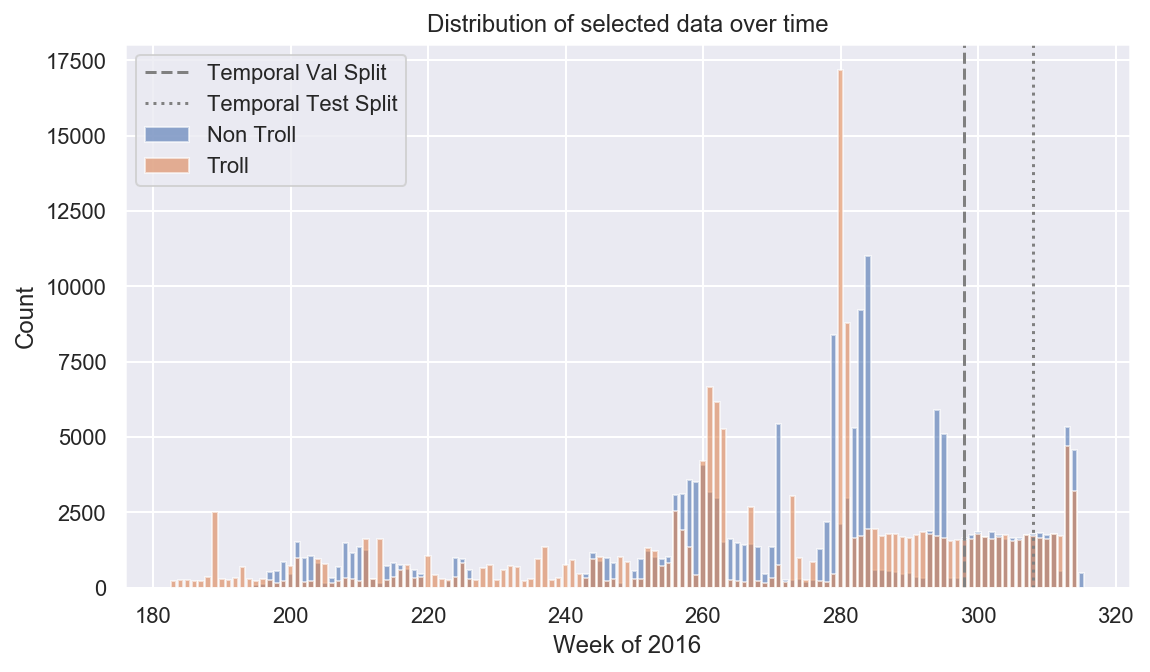

In [92]:
plt.subplots(figsize=(9,5))
plt.bar(nt_dates.index, nt_dates, alpha=.6, label='Non Troll')
plt.bar(t_dates.index, t_dates, alpha=.6, label='Troll')
plt.axvline(val_start_date.dayofyear, c='gray', ls='--', label='Temporal Val Split')
plt.axvline(test_start_date.dayofyear, c='gray', ls=':', label='Temporal Test Split')
plt.xlabel('Week of 2016')
plt.ylabel('Count')
plt.title('Distribution of selected data over time')
plt.legend()
plt.show()